# Reference
https://machinelearningmastery.com/lstm-autoencoders/

# Reconstruction LSTM Autoencoder

The simplest LSTM autoencoder is one that learns to reconstruct each input sequence. <br>
9 time-steps and 1 feature:

In [1]:
# lstm autoencoder recreate sequence
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model

from keras.models import Model
from keras.layers import Input

Define sequence and reshape into preferred shape of \[samples, timesteps, features\]:

In [2]:
# define input sequence
sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# reshape input into [samples, timesteps, features]
n_in = len(sequence)
sequence = sequence.reshape((1, n_in, 1))

Define encoder-decoder LSTM architecture that expects input sequences with 9 time steps and 1 feature and outputs a sequence with 9 time steps and 1 feature.

In [3]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

In [4]:
# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)

In [5]:
plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [6]:
# demonstrate recreation
yhat = model.predict(sequence, verbose=0)
print(yhat[0,:,0])

[0.10802374 0.20397452 0.30119506 0.39925027 0.49797487 0.59741884
 0.697809   0.7995227  0.9030742 ]


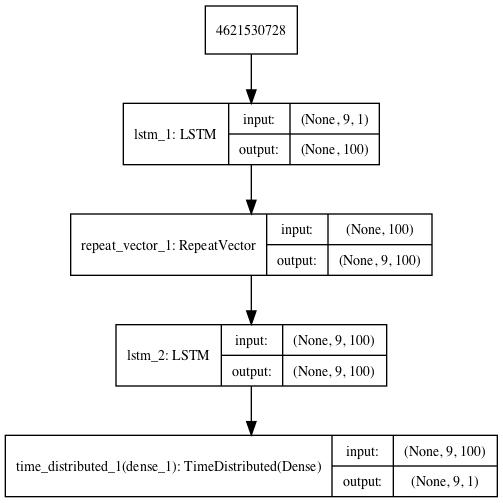

# Prediction LSTM Autoencoder
Modify reconstruction LSTM Autoencoder to instead predict the next step in the sequence.

Expect the output to be the sequence: <br>
`[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]`

Model will expect each input sequence to have 9 time steps and the output sequence to have 8 time steps.

In [7]:
# define input sequence
seq_in = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# reshape input into [samples, timesteps, features]
n_in = len(seq_in)
seq_in = seq_in.reshape((1, n_in, 1))

# prepare output sequence
seq_out = seq_in[:, 1:, :] # 2nd element of seq_in onwards (after reshape)
n_out = n_in - 1

In [8]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

plot_model(model, show_shapes=True, to_file='predict_lstm_autoencoder.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
# fit model
model.fit(seq_in, seq_out, epochs=300, verbose=0)

# demonstrate prediction
yhat = model.predict(seq_in, verbose=0)
print(yhat[0,:,0])

[0.16935384 0.29280564 0.40446398 0.50837654 0.6078973  0.7044157
 0.79912853 0.89311934]


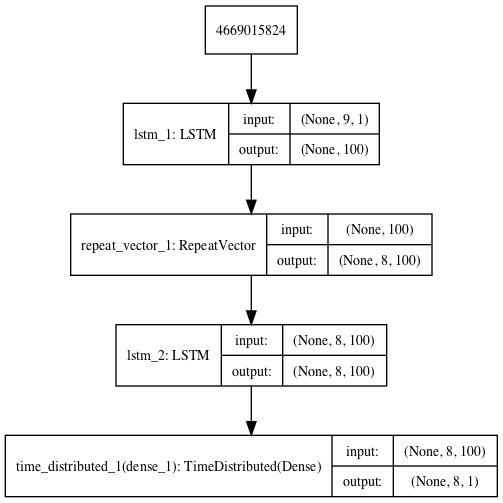

# Composite LSTM Autoencoder
Create a composite LSTM Autoencoder that has a single encoder and 2 decoders, one for reconstruction and one for prediction.

Define encoder:

In [10]:
# define encoder
visible = Input(shape=(n_in,1))
encoder = LSTM(100, activation='relu')(visible)

First decoder that is used for reconstruction:

In [11]:
# define reconstruct decoder
decoder1 = RepeatVector(n_in)(encoder)
decoder1 = LSTM(100, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(1))(decoder1)

Second decoder that is used for prediction:

In [12]:
# define predict decoder
decoder2 = RepeatVector(n_out)(encoder)
decoder2 = LSTM(100, activation='relu', return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(1))(decoder2)

In [13]:
# tie it together
model = Model(inputs=visible, outputs=[decoder1, decoder2])

In [14]:
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [15]:
# fit model
model.fit(seq_in, [seq_in,seq_out], epochs=300, verbose=0)

In [16]:
# demonstrate prediction
yhat = model.predict(seq_in, verbose=0)
print(yhat)

[array([[[0.10854567],
        [0.20597583],
        [0.302922  ],
        [0.39983043],
        [0.49722263],
        [0.5957045 ],
        [0.6959674 ],
        [0.7987982 ],
        [0.9050984 ]]], dtype=float32), array([[[0.1658297 ],
        [0.28886917],
        [0.40262735],
        [0.5093534 ],
        [0.610473  ],
        [0.70704925],
        [0.8000012 ],
        [0.89013433]]], dtype=float32)]


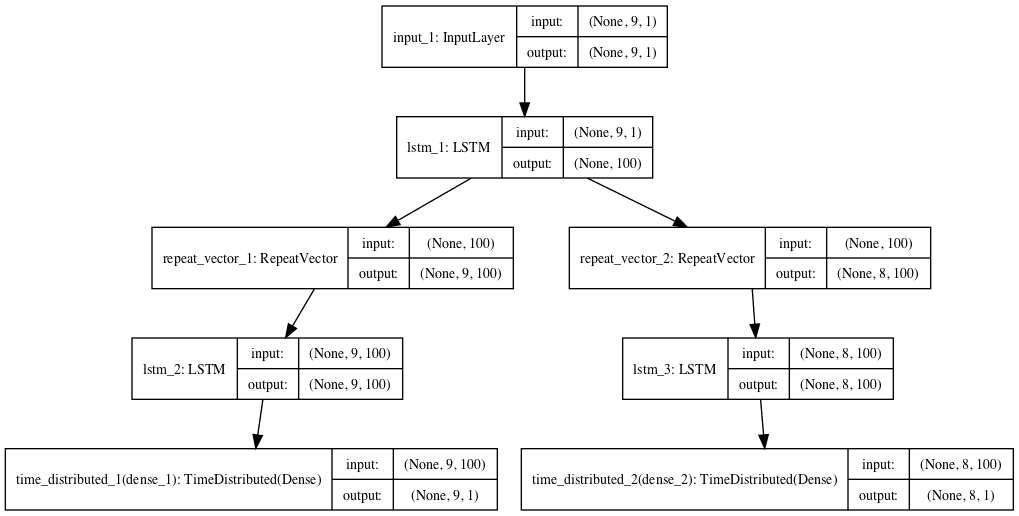

# Keep Standalone LSTM Encoder
Once autoencoder has been fit, the decoder can be removed and the encoder can be kept as a standalone model.

The encoder can be used to transform input sequences to a fixed length encoded vector.

Create a new model that has the same inputs as original model, and outputs directly from the end of encoder model, before the `RepeatVector` layer.

In [17]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)

In [18]:
# connect the encoder LSTM as the output layer
model = Model(inputs=model.inputs, outputs=model.layers[0].output)
plot_model(model, show_shapes=True, to_file='lstm_encoder.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Predict the sequence and get back the 100 element output of the encoder.

In [19]:
# get the feature vector for the input sequence
yhat = model.predict(sequence)
print(yhat.shape)
print(yhat)

1/1 [==============================] - 0s 226ms/step
(1, 100)
[[0.04588479 0.03573649 0.         0.04737705 0.         0.
  0.08150392 0.         0.         0.00568952 0.01565594 0.
  0.02592465 0.0408755  0.         0.09614272 0.1290739  0.
  0.         0.         0.07475773 0.         0.         0.09499974
  0.         0.         0.0580228  0.09357021 0.09709301 0.09615061
  0.03903631 0.00410925 0.         0.08957739 0.         0.
  0.12137134 0.0378059  0.         0.         0.         0.05503175
  0.08687729 0.02462975 0.07152317 0.08842088 0.         0.
  0.03739825 0.         0.06797485 0.04894598 0.04917474 0.
  0.02574052 0.         0.         0.         0.         0.
  0.03728311 0.02250903 0.         0.         0.         0.10753236
  0.         0.07324821 0.0389988  0.         0.         0.
  0.02753257 0.02540717 0.         0.06955361 0.         0.00883427
  0.07005215 0.         0.         0.         0.04168067 0.
  0.02950752 0.00276996 0.05426683 0.01511476 0.         0

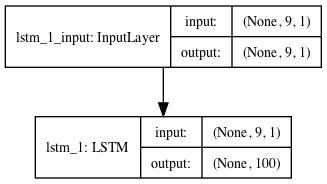